# CUSTOMER CHURN PREDICTION


### CONTENT

Each row represents a customer, each column contains customer’s attributes described on the column Metadata.

The data set includes information about:

1. Customers who left within the last month – the column is called Churn
2. Services that each customer has signed up for – phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV and movies
3. Customer account information – how long they’ve been a customer, contract, payment method, paperless billing, monthly charges, and total charges
4. Demographic info about customers – gender, age range, and if they have partners and dependents

### 1. LOAD LIBRARIES

In [1]:
!pip install imbalanced-learn

In [2]:
import joblib
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mlxtend import plotting
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve
from imblearn.over_sampling import SMOTE

warnings.filterwarnings('ignore')
pd.options.display.max_columns = None

### 2. LOAD DATA

In [3]:
data = pd.read_csv('https://raw.githubusercontent.com/SravaniRVS/DATA-606/main/Telco-Customer-Churn.csv') # Load data

print(f"Data Shape : {data.shape}") # Get shape

data.head() # Top 5 rows

Data Shape : (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


### 3. DATA CLEANING

#### 3.1 DATATYPE CHECK AND CONVERSION

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [5]:
# the TotalCharges column is present as object, whereas it should be in float
print(sorted(data['TotalCharges'].unique())[0:5])

[' ', '100.2', '100.25', '100.35', '100.4']


In [6]:
## it has a value present as ' ', which can be count as null
## replacing ' ' to np.nan
data['TotalCharges'] = data['TotalCharges'].replace(' ', np.nan)

In [7]:
## convert TotalCharges into float
data['TotalCharges'] = data['TotalCharges'].astype(float)

In [8]:
# convert Churn column into binary output
data['Churn_binary'] = data['Churn'].map({'No': 0, "Yes" : 1})

In [9]:
data.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                object
Churn_binary          int64
dtype: object

#### 3.2 NULL VALUE ANALYSIS

In [10]:
data.isnull().sum() ## check for null values

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
Churn_binary         0
dtype: int64

In [11]:
## only TotalCharges has null values, count 11
## as the percentage of null values are very less as compared to the total rows in dataset
## we can remove these rows
## as total charges might be an important column for customer churn, so as it is unknown
## imputing might not be a good option
data = data.dropna().reset_index(drop=True)
print(f"New Shape : {data.shape}")

New Shape : (7032, 22)


In [12]:
data.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
Churn_binary        0
dtype: int64

#### 3.3 DATA DUPLICATION ANALYSIS

In [13]:
data[data.duplicated()] # no duplicate rows present in the dataset

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,Churn_binary


#### 3.4 PONTETIAL JUNK VALUE CHECK

In [14]:
data.describe() # no potential junk values can be seen

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn_binary
count,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000
mean,0.162400,32.421786,64.798208,2283.300441,0.265785
std,0.368844,24.545260,30.085974,2266.771362,0.441782
min,0.000000,1.000000,18.250000,18.800000,0.000000
25%,0.000000,9.000000,35.587500,401.450000,0.000000
50%,0.000000,29.000000,70.350000,1397.475000,0.000000
75%,0.000000,55.000000,89.862500,3794.737500,1.000000
max,1.000000,72.000000,118.750000,8684.800000,1.000000


### 4. CHRUN ANALYSIS

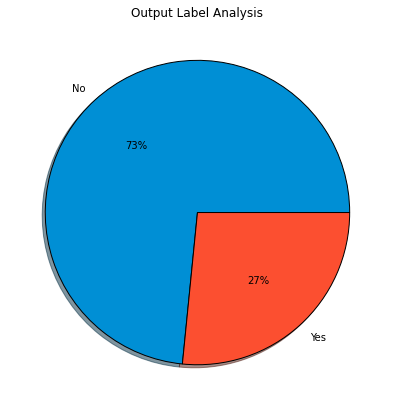

In [15]:
target = data['Churn'].value_counts().to_dict()
plt.figure(figsize=(7,7))
plt.pie(target.values(), labels = target.keys(), 
        wedgeprops={'edgecolor': 'black'}, 
        colors = ['#008fd5', '#fc4f30'], 
        autopct='%.0f%%', 
        shadow=True)
plt.title('Output Label Analysis')
plt.show()

<span  style="color:green; font-size:14px">
    
*The pie chart shows that the dataset is imbalanced, with 27% only of the data belongs to churn class.*
</span>

### 5. HELPER FUNCTIONS

In [16]:
def distibution_plot_v1(data, column_list, num_row, num_col, figsize = (15,5)):
    fig = plt.figure(figsize=figsize)
    for idx, column in enumerate(column_list):
        plt.subplot(num_row, num_col, idx+1)
        plot = sns.distplot(data[column])
        plt.title(column)
        plt.xlabel('')
    plt.show()

In [17]:
def distibution_plot_v2(data, column_list, target_column, target_labels, num_row, num_col,
                        figsize = (15,5)):
    fig = plt.figure(figsize=figsize)
    for idx, column in enumerate(column_list):
        plt.subplot(num_row, num_col, idx+1)
        # Plot distribution plot for both labels present in the target
        sns.distplot(data[data[target_column] == target_labels[0]][column])
        sns.distplot(data[data[target_column] == target_labels[1]][column])
        plt.title(column)
        plt.legend(['No', 'Yes'])
        plt.xlabel('')
    plt.show()

In [18]:
def box_plot(data, column_list, target_column, target_labels, num_row, num_col,
                        figsize = (15,5)):
    
    fig = plt.figure(figsize=figsize)
    for idx, column in enumerate(column_list):
        plt.subplot(num_row, num_col, idx+1)
        # Plot distribution plot for both labels present in the target
        sns.boxplot(x=target_column, y=column, data=data)
        plt.title(column)
        plt.legend(target_labels)
        plt.xlabel('')
    plt.show()

### 6. EXPLORATORY DATA ANALYSIS

#### 6.1DISTRIBUTION PLOT ANALYSIS OF MONTHLY, AND TOTAL CHARGES

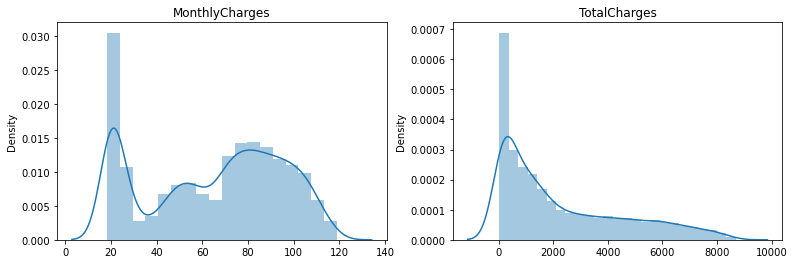

In [19]:
charges_column_list = ['MonthlyCharges', 'TotalCharges']
output_colmn_name = 'Churn_binary'
output_labels = [0, 1]

# Get distribution plot
distibution_plot_v1(data, charges_column_list, num_row = 1, num_col = 2, figsize = (13,4))

In [20]:
# Degree of skewness for charges columns
monthly_skewness = data['MonthlyCharges'].skew()
total_skewness = data['TotalCharges'].skew()

print(f"MonthlyCharges skewness: {monthly_skewness : .4f}")
print(f"TotalCharges skewness  : {total_skewness : .4f}", )

MonthlyCharges skewness: -0.2221
TotalCharges skewness  :  0.9616


<span  style="color:green; font-size:14px">
    
*From distibution plots and skewness value we can determine, TotalCharges column is highly right-skewed, whereas MonthlyCharges is slightly left skewed.*

 </span>

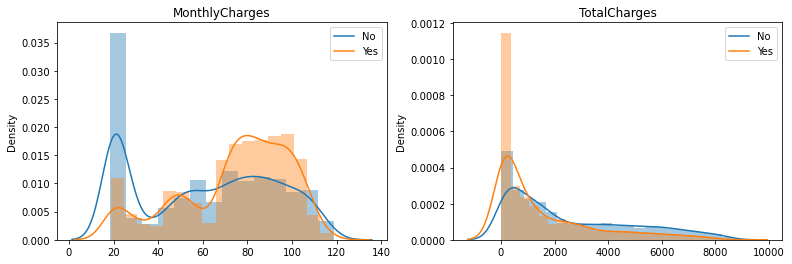

In [21]:
distibution_plot_v2(data, charges_column_list, output_colmn_name, output_labels,
                    num_row = 1, num_col = 2, figsize = (13,4))

<span  style="color:green; font-size:14px">
    
*Distribution plot of both charges column for churned customer and non-churned customers are almost overlapping for total charges whereas it is slightly different in case of monthly charges. Still they are not significantly different from each other.*
  </span>

#### 6.2 BOX PLOT ANALYSIS OF MONTHLY, AND TOTAL CHARGES

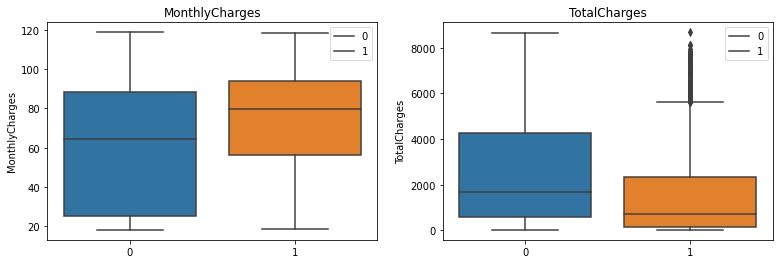

In [22]:
box_plot(data, charges_column_list, output_colmn_name, output_labels,num_row = 1, 
         num_col = 2, figsize = (13,4))

<span  style="color:green; font-size:14px">
    
*This plot shows the distribution of monthly charges for each value of the 'Churn' column (i.e., customers who churned vs. those who did not). We can see that customers who churned tend to have higher monthly charges, and have low total charges.*
</span>

#### 6.3 BIVARIATE ANALYSIS: CONTRACT VS. CHURN

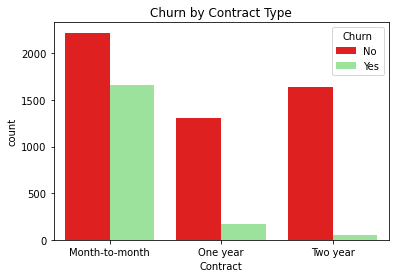

In [23]:
sns.countplot(x='Contract', hue='Churn', data=data, palette=['red', 'lightgreen'])
plt.title('Churn by Contract Type')
plt.show()

<span  style="color:green; font-size:14px">
    
*This plot shows the number of customers in each contract type for each value of the 'Churn' column. We can see that customers on month-to-month contracts are more likely to churn than those on longer-term contracts.*

 </span>

#### 6.4 MULTIVARIATE ANALYSIS: MONTHLYCHARGES VS. CHURN BY CONTRACT

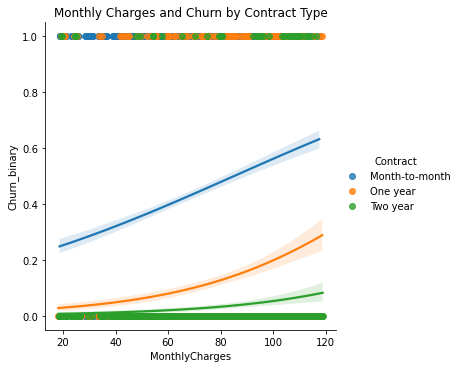

In [24]:
sns.lmplot(x='MonthlyCharges', y='Churn_binary', hue='Contract', data=data, logistic=True)
plt.title('Monthly Charges and Churn by Contract Type')
plt.show()

<span  style="color:green; font-size:14px">

*This plot shows the relationship between monthly charges, churn, and contract type. The logistic regression lines show the probability of churn based on monthly charges for each contract type. We can see that the relationship between monthly charges and churn differs for customers on different types of contracts.*

*It shows with increase in monthly charges for month to month contract has a linear relationship with the churn probability. As we have already seen high monthly charges are the reason of most of the churn customer. But If we combine high monthly charge with month-to-month contract the probability of churn gets high.*

 </span>

#### 6.6 CHURN ANALYSIS BASED ON CUSTOMER DEMOGRAPHICS

In [26]:
# Analyze the churn rate
churn_rate = data["Churn"].value_counts(normalize=True) * 100
print("Churn Rate:")
churn_rate

Churn Rate:


No     73.421502
Yes    26.578498
Name: Churn, dtype: float64

In [27]:
# Calculate the percentage of customers who churned based on gender
gender_churn_rate = data.groupby(['gender', 'Churn'])['Churn'].count().unstack()
gender_churn_rate['total'] = gender_churn_rate.sum(axis=1)
gender_churn_rate['Churn_rate'] = round(gender_churn_rate['Yes'] / gender_churn_rate['total'] * 100, 2)
print("\nGender Churn Rate:")
gender_churn_rate


Gender Churn Rate:


Churn,No,Yes,total,Churn_rate
gender,,,,
Female,2544,939,3483,26.96
Male,2619,930,3549,26.20


In [28]:
# Calculate the percentage of customers who churned based on senior citizen status
senior_churn_rate = data.groupby(['SeniorCitizen', 'Churn'])['Churn'].count().unstack()
senior_churn_rate['total'] = senior_churn_rate.sum(axis=1)
senior_churn_rate['Churn_rate'] = round(senior_churn_rate['Yes'] / senior_churn_rate['total'] * 100, 2)
print("Senior Citizen Churn Rate:")
senior_churn_rate

Senior Citizen Churn Rate:


Churn,No,Yes,total,Churn_rate
SeniorCitizen,,,,
0,4497,1393,5890,23.65
1,666,476,1142,41.68


In [29]:
# Calculate the percentage of customers who churned based on partner status
partner_churn_rate = data.groupby(['Partner', 'Churn'])['Churn'].count().unstack()
partner_churn_rate['total'] = partner_churn_rate.sum(axis=1)
partner_churn_rate['Churn_rate'] = round(partner_churn_rate['Yes'] / partner_churn_rate['total'] * 100, 2)
print("Partner Churn Rate:")
partner_churn_rate

Partner Churn Rate:


Churn,No,Yes,total,Churn_rate
Partner,,,,
No,2439,1200,3639,32.98
Yes,2724,669,3393,19.72


In [30]:
# Calculate the percentage of customers who churned based on dependent status
dependent_churn_rate = data.groupby(['Dependents', 'Churn'])['Churn'].count().unstack()
dependent_churn_rate['total'] = dependent_churn_rate.sum(axis=1)
dependent_churn_rate['Churn_rate'] = round(dependent_churn_rate['Yes'] / dependent_churn_rate['total'] * 100,2)
print("Dependent Churn Rate:")
dependent_churn_rate

Dependent Churn Rate:


Churn,No,Yes,total,Churn_rate
Dependents,,,,
No,3390,1543,4933,31.28
Yes,1773,326,2099,15.53


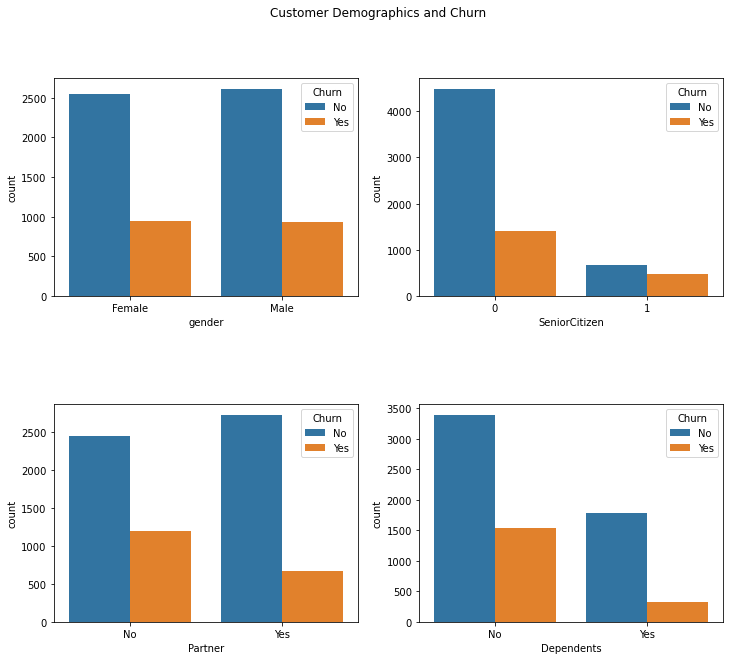

In [31]:
# Create a grid of plots for customer demographics
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
sns.countplot(x='gender', hue='Churn', data=data, ax=ax[0][0])
sns.countplot(x='SeniorCitizen', hue='Churn', data=data, ax=ax[0][1])
sns.countplot(x='Partner', hue='Churn', data=data, ax=ax[1][0], order=['No', 'Yes'])
sns.countplot(x='Dependents', hue='Churn', data=data, ax=ax[1][1])
plt.subplots_adjust(hspace=0.5)
plt.suptitle('Customer Demographics and Churn')
plt.show()

<span  style="color:green; font-size:14px">
    
*The senior citizen and gender doesn't have a strong relationship with churn column. Customer's having no partner or no dependent has highly likely to chrun as compared to those have partners or dependents.*

</span>

#### 6.6 CHURN ANALYSIS BASED ON SERVICE TAKEN BY CUSTOMERS

In [32]:
# Calculate the percentage of customers who churned based on PhoneService
phone_churn_rate = data.groupby(['PhoneService', 'Churn'])['Churn'].count().unstack()
phone_churn_rate['total'] = phone_churn_rate.sum(axis=1)
phone_churn_rate['Churn_rate'] = round(phone_churn_rate['Yes'] / phone_churn_rate['total'] * 100, 2)
print("Phone Service Churn Rate:")
phone_churn_rate

Phone Service Churn Rate:


Churn,No,Yes,total,Churn_rate
PhoneService,,,,
No,510,170,680,25.00
Yes,4653,1699,6352,26.75


In [33]:
# Calculate the percentage of customers who churned based on MultipleLines
multi_churn_rate = data.groupby(['MultipleLines', 'Churn'])['Churn'].count().unstack()
multi_churn_rate['total'] = multi_churn_rate.sum(axis=1)
multi_churn_rate['Churn_rate'] = round(multi_churn_rate['Yes'] / multi_churn_rate['total'] * 100, 2)
print("Multiple Lines Churn Rate:")
multi_churn_rate


Multiple Lines Churn Rate:


Churn,No,Yes,total,Churn_rate
MultipleLines,,,,
No,2536,849,3385,25.08
No phone service,510,170,680,25.00
Yes,2117,850,2967,28.65


In [34]:
# Calculate the percentage of customers who churned based on InternetService
internet_churn_rate = data.groupby(['InternetService', 'Churn'])['Churn'].count().unstack()
internet_churn_rate['total'] = internet_churn_rate.sum(axis=1)
internet_churn_rate['Churn_rate'] = round(internet_churn_rate['Yes'] / internet_churn_rate['total'] * 100, 2)
print("\nInternet Service Churn Rate:")
internet_churn_rate


Internet Service Churn Rate:


Churn,No,Yes,total,Churn_rate
InternetService,,,,
DSL,1957,459,2416,19.00
Fiber optic,1799,1297,3096,41.89
No,1407,113,1520,7.43


In [35]:
# Calculate the percentage of customers who churned based on StreamingTV
stream_tv_churn_rate = data.groupby(['StreamingTV', 'Churn'])['Churn'].count().unstack()
stream_tv_churn_rate['total'] = stream_tv_churn_rate.sum(axis=1)
stream_tv_churn_rate['Churn_rate'] = round(stream_tv_churn_rate['Yes'] / stream_tv_churn_rate['total'] * 100, 2)
print("\nStreaming TV Churn Rate:")
stream_tv_churn_rate


Streaming TV Churn Rate:


Churn,No,Yes,total,Churn_rate
StreamingTV,,,,
No,1867,942,2809,33.54
No internet service,1407,113,1520,7.43
Yes,1889,814,2703,30.11


In [36]:
# Calculate the percentage of customers who churned based on StreamingMovies
stream_movies_churn_rate = data.groupby(['StreamingMovies', 'Churn'])['Churn'].count().unstack()
stream_movies_churn_rate['total'] = stream_movies_churn_rate.sum(axis=1)
stream_movies_churn_rate['Churn_rate'] = round(stream_movies_churn_rate['Yes'] / stream_movies_churn_rate['total'] * 100, 2)
print("\nStreaming Movies Churn Rate:")
stream_movies_churn_rate


Streaming Movies Churn Rate:


Churn,No,Yes,total,Churn_rate
StreamingMovies,,,,
No,1843,938,2781,33.73
No internet service,1407,113,1520,7.43
Yes,1913,818,2731,29.95


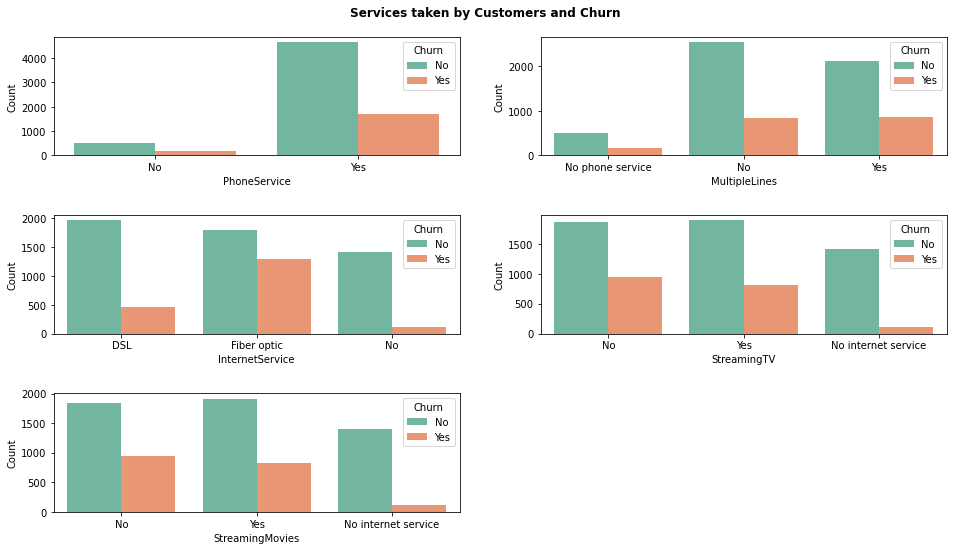

In [37]:
# Create a grid of plots for services taken by customers

plt.figure(figsize=(16, 14))

features = ['PhoneService', 'MultipleLines', 'InternetService', 'StreamingTV', 'StreamingMovies']
target = data['Churn']

for i, col in enumerate(features):
    plt.subplot( len(features),2, i+1)
    x = data[col]
    y = target
    sns.countplot(x = x,hue=y, palette = 'Set2')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.subplots_adjust(hspace=0.5, top=0.95)
    plt.suptitle('Services taken by Customers and Churn', fontweight='bold')

<span  style="color:green; font-size:14px">
    
*The below are the observations taken from the features which are related to services taken by customers.*

1. Those customers who have taken Fibre Optics as the internet service are most likely to churn.
2. Customer's having streaming and TV services has high customer churn as compared to those doesn't have any internet services.

</span>

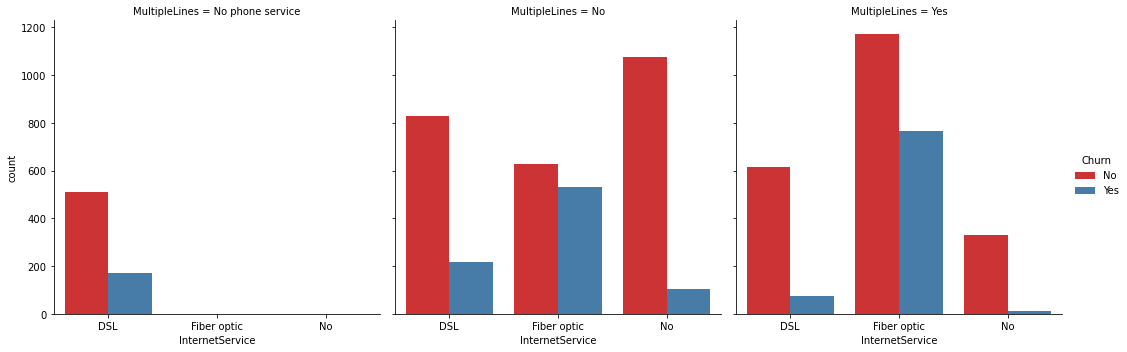

In [38]:
# Multivariate Analysis
sns.catplot(x='InternetService', hue='Churn', col='MultipleLines', data=data, kind='count',palette = 'Set1')
plt.show()

<span  style="color:green; font-size:14px">
    
*Customers having Fibre optics and multiple line are high likely to churn.*
</span>

#### 6.7 CHURN ANALYSIS BASED ON TENURE OF SERVICE

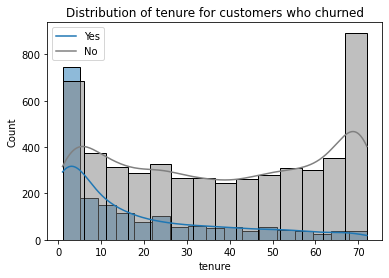

In [39]:
# Distribution of tenure for customers who churned and who didn't churn
sns.histplot(data=data[data['Churn']=='Yes'], x='tenure', kde=True)
sns.histplot(data=data[data['Churn']=='No'], x='tenure', kde=True, color = 'gray')
plt.title('Distribution of tenure for customers who churned')
plt.legend(['Yes', 'No'])
plt.show()

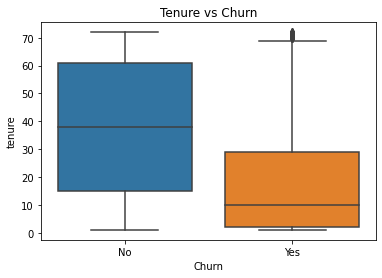

In [40]:
sns.boxplot(data=data, x='Churn', y='tenure')
plt.title('Tenure vs Churn')
plt.show()

<span  style="color:green; font-size:14px">
    
*From these plots, we can see that the customers who churned tend to have lower tenures compared to those who didn't churn. We can see that the median tenure for customers who churned is lower than that of customers who didn't churn.*
 </span>

In [41]:
# Create tenure ranges
tenure_ranges = [(0, 12), (12, 24), (24, 36), (36, 48), (48, 60), (60, 72)]
churn_rates = []

# Calculate churn rate for each tenure range
for i, tenure_range in enumerate(tenure_ranges):
    churn_rate = data[(data['tenure'] >= tenure_range[0]) & (data['tenure'] < tenure_range[1])]['Churn_binary'].mean()
    print(f"Tenure range {i+1}: {round(churn_rate*100, 2)}%")
    churn_rates.append(round(churn_rate*100, 2))

Tenure range 1: 48.54%
Tenure range 2: 29.51%
Tenure range 3: 22.03%
Tenure range 4: 19.52%
Tenure range 5: 15.0%
Tenure range 6: 8.3%


<span  style="color:green; font-size:14px">
    
*We can see that the churn rate tends to be higher for customers with lower tenures.*
</span>

#### 6.8 CHURN ANALYSIS BASED ON ONLINE SECURITY AND BACKUP

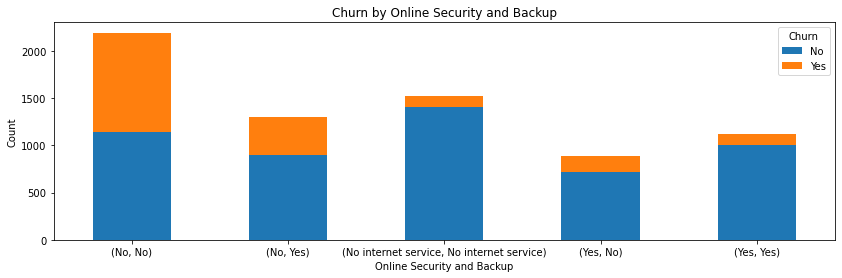

In [42]:
# Creating a contingency table and visualize the results using a stacked bar chart
table = pd.crosstab([data['OnlineSecurity'], data['OnlineBackup']], data['Churn'])

table.plot(kind='bar', stacked=True, figsize=(14,4))
plt.xticks(rotation=0)
plt.xlabel('Online Security and Backup')
plt.ylabel('Count')
plt.legend(title='Churn', loc='upper right')
plt.title('Churn by Online Security and Backup')
plt.show()

In [43]:
table['total'] = table.sum(axis=1)
table['churn_rate'] = round(table['Yes'] / table['total'] * 100, 2)
print("Online Security and Backup Churn Rate:")
table

Online Security and Backup Churn Rate:


Churn                                      No   Yes  total  churn_rate
OnlineSecurity      OnlineBackup                                      
No                  No                   1138  1057   2195       48.15
                    Yes                   898   404   1302       31.03
No internet service No internet service  1407   113   1520        7.43
Yes                 No                    716   176    892       19.73
                    Yes                  1004   119   1123       10.60

<span  style="color:green; font-size:14px">
    
*From the chart, we can see that customers who do not have online security or backup are more likely to churn than those who have these services. Additionally, customers who have online security and backup are less likely to churn than those who have only one of these services or none at all.*

 </span>

#### 6.8 CHURN ANALYSIS BASED ON PAYMENT METHOD AND BIILING

Churn                    No        Yes
PaperlessBilling                      
No                83.624302  16.375698
Yes               66.410749  33.589251


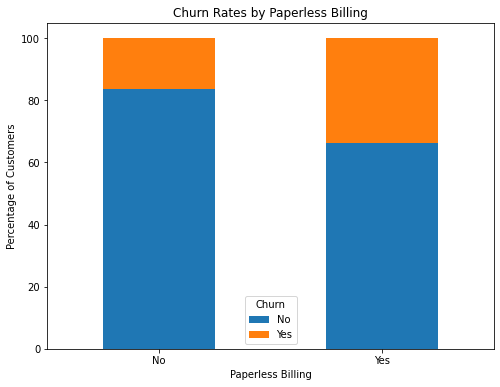

In [44]:
# create cross-tabulation table of PaperlessBilling and Churn
paperless_churn = pd.crosstab(data['PaperlessBilling'], data['Churn'], normalize='index') * 100
print(paperless_churn)

# plot bar chart of churn rates for each category of PaperlessBilling
ax = paperless_churn.plot(kind='bar', stacked=True, figsize=(8,6))
plt.title('Churn Rates by Paperless Billing')
plt.xlabel('Paperless Billing')
plt.ylabel('Percentage of Customers')
plt.xticks(rotation=0)
plt.legend(title='Churn', loc='best')
plt.show()


<span  style="color:green; font-size:14px">
    
*Customers who use paperless billing are slightly more likely to churn. This suggests that the company should investigate why this is the case and consider offering incentives or other measures to encourage customers to switch to paperless billing.*

</span>


Churn                             No        Yes
PaymentMethod                                  
Bank transfer (automatic)  83.268482  16.731518
Credit card (automatic)    84.746877  15.253123
Electronic check           54.714588  45.285412
Mailed check               80.798005  19.201995


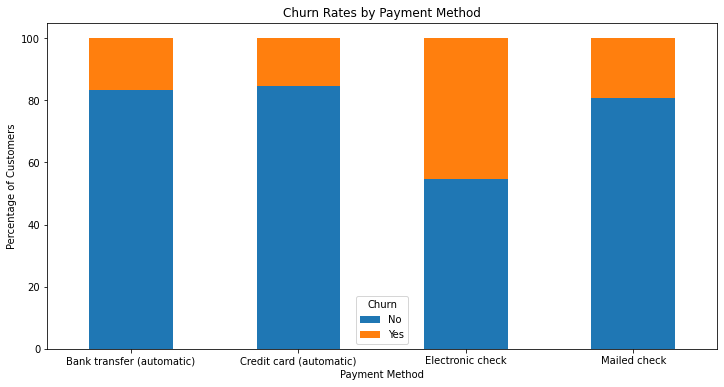

In [45]:
# create cross-tabulation table of PaymentMethod and Churn
payment_churn = pd.crosstab(data['PaymentMethod'], data['Churn'], normalize='index') * 100
print(payment_churn)


# plot bar chart of churn rates for each category of PaymentMethod
ax = payment_churn.plot(kind='bar', stacked=True, figsize=(12,6))
plt.title('Churn Rates by Payment Method')
plt.xlabel('Payment Method')
plt.ylabel('Percentage of Customers')
plt.xticks(rotation=0)
plt.legend(title='Churn', loc='best')
plt.show()



<span  style="color:green; font-size:14px">
    
*Customers who pay by electronic check are more likely to churn than those who pay by other methods.*

</span>

#### 6.9 CORRELATION ANALYSIS

Text(0.5, 1.0, 'Correlation Matrix')

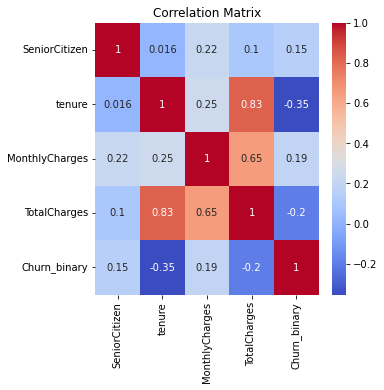

In [46]:
# get correalted values
corr_df = data.corr()
plt.figure(figsize=(5,5))
sns.heatmap(corr_df, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')

<span  style="color:green; font-size:14px">
    
*There is a multi-collinearity present between total charges and tenure. It means with increase in tenure the customers tend to charged more. This might be the reason as customer stays longer with a telecom vendor they most likely to take other services as well.*
 </span>


#### 6.10 CHURN ANALYSIS WITH TOTAL CHARGES AND TENURE

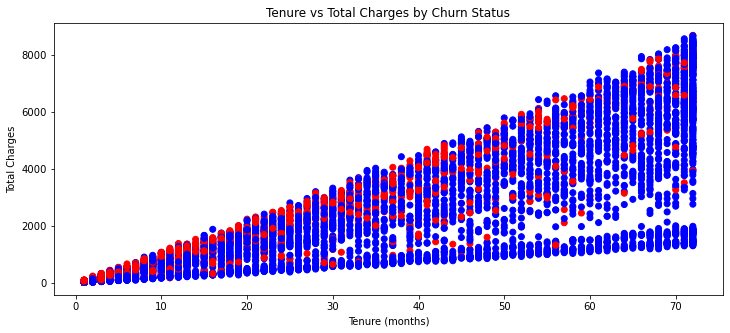

In [47]:
churn_colors = {'No': 'blue', 'Yes': 'red'}
data['Churn_color'] = data['Churn'].map(churn_colors)

plt.figure(figsize=(12,5))
plt.scatter(data['tenure'], data['TotalCharges'], c=data['Churn_color'])
plt.xlabel('Tenure (months)')
plt.ylabel('Total Charges')
plt.title('Tenure vs Total Charges by Churn Status')
plt.show()

# Drop churn color
data = data.drop(columns = ['Churn_color'])

<span  style="color:green; font-size:14px">
    
*The customer churn rate is decreasing with increase in tenure and total charges. Most of the customers are retained with increase in tenure.*</span>

### 7. DATA TRANSFORMATION

#### 7.1 LABEL ENCODING ON CATEGORICAL FEATURES

In [48]:
cat_cols = ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService',
            'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
            'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']

In [49]:
from sklearn.preprocessing import LabelEncoder

data_labeled = data.copy()

# encoder dictionary
label_enc_dict = {}

# Iterate over categorical columns and perform label encoding
for col in cat_cols:
    # Initialize LabelEncoder object
    le = LabelEncoder()
    # Fit and transform data
    data_labeled[col] = le.fit_transform(data_labeled[col])
    label_enc_dict[col] = le

# Dump Data
joblib.dump(label_enc_dict, 'label_encoder_dictionary')

['label_encoder_dictionary']

In [50]:
print(f"Encoded Data Shape : {data_labeled.shape}")
data_labeled.head()

Encoded Data Shape : (7032, 22)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,Churn_binary
0,7590-VHVEG,0,0,1,0,1,0,1,0,0,2,0,0,0,0,0,1,2,29.85,29.85,No,0
1,5575-GNVDE,1,0,0,0,34,1,0,0,2,0,2,0,0,0,1,0,3,56.95,1889.50,No,0
2,3668-QPYBK,1,0,0,0,2,1,0,0,2,2,0,0,0,0,0,1,3,53.85,108.15,Yes,1
3,7795-CFOCW,1,0,0,0,45,0,1,0,2,0,2,2,0,0,1,0,0,42.30,1840.75,No,0
4,9237-HQITU,0,0,0,0,2,1,0,1,0,0,0,0,0,0,0,1,2,70.70,151.65,Yes,1


### 8. DATA SPLIT

In [51]:
y = data_labeled['Churn_binary']
X = data_labeled.drop(columns = ['Churn_binary', 'Churn', 'customerID'])

# Split Data
X_train_le, X_test_le, Y_train_le, Y_test_le = train_test_split(X, y, test_size = 0.20, stratify = y,
                                                               random_state = 42)
X_train_le.shape, X_test_le.shape, Y_train_le.shape, Y_test_le.shape

((5625, 19), (1407, 19), (5625,), (1407,))

### 9. MODELLING HELPER FUNCTIONS

In [52]:
def model_training(model_name, model, param_grid, X_train, y_train, random=False, scoring='f1'):
    
    print(f"Training started for : \033[1;31m{model_name}\033[0m")
    print("\033[1;31m-------------------------------------------\033[0m\n")
    if random == True:
        clf = RandomizedSearchCV(model, param_grid, verbose=1, n_jobs=-1, cv=5, scoring = scoring)
    else:
        clf = GridSearchCV(model, param_grid, verbose=1, n_jobs=-1, cv=5, scoring = scoring)
    clf.fit(X_train, y_train)
    print(f"\033[1;31mBest Parameters :\033[0m{clf.best_params_}\n")
    print(f"\033[1;31mBest {scoring} Score : \033[0m{clf.best_score_:.2f}\n")
    
    ## training on best estimator
    model = clf.best_estimator_
    model.fit(X_train, y_train)
    return model


In [53]:
def evaluate_model(model_name, model, X_train, X_test, y_train, y_test):
    
    # Make predictions train on the test data
    y_pred_tr = model.predict(X_train)
    f1_tr = f1_score(y_train, y_pred_tr)
    accuracy_tr = accuracy_score(y_train, y_pred_tr)
    
    # Make predictions on the test data
    y_pred = model.predict(X_test)

    # Calculate various classification metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    class0_acc = accuracy_score(y_test[y_test==0], y_pred[y_test==0])
    class1_acc = accuracy_score(y_test[y_test==1], y_pred[y_test==1])
    roc_score = roc_auc_score(y_test, y_pred)
    auc = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])

    # Return the metrics in a dataframe
    return pd.DataFrame({
        'model' : [model_name],
        'accuracy_train': [accuracy_tr],
        'accuracy_test': [accuracy],
        'f1_train' : [f1_tr],
        'f1_test': [f1],
        'roc_score': [roc_score],
        'auc_score': [auc]
    })

In [54]:
def validation_plots(model_name, model, X_train, X_test, y_train, y_test):
    
    # Make predictions on the train data
    y_train_pred = model.predict(X_train)
    train_report = classification_report(y_train, y_train_pred)
    print(f"\033[1;31mTraining Classification Report of {model_name}:\033[0m")
    print("\033[1;31m----------------------------------------------------------\033[0m")
    print(train_report,"\n")
    
    # Make predictions on the test data
    y_test_pred = model.predict(X_test)
    test_report = classification_report(y_test, y_test_pred)
    print(f"\033[1;31mTesting Classification Report of {model_name}:\033[0m")
    print("\033[1;31m----------------------------------------------------------\033[0m")
    print(test_report)
        
    fig = plt.figure(figsize=(15,10))
    
    ## generate tpr, fpr scores for different threshold of probability
    ## for roc auc curve
    fpr_tr, tpr_tr, threshold_tr = roc_curve(y_train, model.predict_proba(X_train)[:, 1])
    fpr_te, tpr_te, threshold_te = roc_curve(y_test, model.predict_proba(X_test)[:,1])
    ## get auc score
    auc_train = roc_auc_score(y_train, model.predict_proba(X_train)[:,1])
    auc_test = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
    
    ## plot roc curves
    plt.subplot(221)
    plt.plot(fpr_tr, tpr_tr, label = "train auc - " + str(round(auc_train ,2)))
    plt.plot(fpr_te, tpr_te, label = "test auc - "  + str(round(auc_test ,2)))
    plt.legend()
    plt.ylabel('True Positive Rate', fontsize=15)
    plt.xlabel('False Positive Rate', fontsize=15)
    plt.title('ROC Curve', fontsize=18)
    
    ## plot roc auc score
    plt.subplot(222)
    conf_matrix = confusion_matrix(y_test, y_test_pred)
    plot = sns.heatmap(conf_matrix, cbar=False, fmt = '2g', annot=True, cmap = 'Blues')
    plt.title("Confusion Matrix", fontsize=18)
    plt.xlabel('Predicted', fontsize=15)
    plt.ylabel('Actuals', fontsize=15)
    plt.show()

In [55]:
def smote_analysis(model_name, model, param_grid, X_train, y_train, smote=True, random=False, scoring='f1'):
    
    if smote == True:
        print("\033[1;31mBefore SMOTE:\033[0m")
        print("\033[1;31m-------------------\033[0m")
        print(f"Number of positive samples: {sum(y_train==1)}")
        print(f"Number of negative samples: {sum(y_train==0)}\n")
        print(f"Performing SMOTE for \033[1;31m{model_name}......\033[0m\n")
        smote = SMOTE(random_state=42)
        X_train, y_train = smote.fit_resample(X_train, y_train)
        print("\033[1;31mAfter SMOTE:\033[0m")
        print("\033[1;31m-------------------\033[0m")
        print(f"Number of positive samples: {sum(y_train==1)}")
        print(f"Number of negative samples: {sum(y_train==0)}\n")
    
    print(f"\033[1;31mTraining started for : {model_name}\033[0m")
    print("\033[1;31m----------------------------------------\033[0m\n")
    if random == True:
        clf = RandomizedSearchCV(model, param_grid, verbose=1, n_jobs=-1, cv=5, scoring = scoring)
    else:
        clf = GridSearchCV(model, param_grid, verbose=1, n_jobs=-1, cv=5, scoring = scoring)
    clf.fit(X_train, y_train)
    print(f"\033[1;31mBest Parameters :\033[0m{clf.best_params_}")
    print(f"\033[1;31mBest {scoring} Score : \033[0m{clf.best_score_:.2f}\n")
    
    ## training on best estimator
    model = clf.best_estimator_
    model.fit(X_train, y_train)
    return model


### 10. MODELS

#### 10.1 LOGISTIC REGRESSION

Training started for : LOGISTIC_REG
-------------------------------------------

Fitting 5 folds for each of 72 candidates, totalling 360 fits


/Users/sravaniravulaparthi/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/sravaniravulaparthi/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/sravaniravulaparthi/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/sravaniravulaparthi/opt/anaconda3/lib/python3.9/s

/Users/sravaniravulaparthi/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/sravaniravulaparthi/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/mod

/Users/sravaniravulaparthi/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/sravaniravulaparthi/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/sravaniravulaparthi/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or

/Users/sravaniravulaparthi/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/sravaniravulaparthi/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/mod

/Users/sravaniravulaparthi/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/sravaniravulaparthi/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/sravaniravulaparthi/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or

/Users/sravaniravulaparthi/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/sravaniravulaparthi/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/sravaniravulaparthi/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or

/Users/sravaniravulaparthi/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/sravaniravulaparthi/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/sravaniravulaparthi/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or

Best Parameters :{'C': 100, 'class_weight': 'balanced', 'penalty': 'l2'}

Best f1 Score : 0.63

Training Classification Report of Logistic Regression:
----------------------------------------------------------
              precision    recall  f1-score   support

           0       0.91      0.74      0.82      4130
           1       0.53      0.79      0.63      1495

    accuracy                           0.75      5625
   macro avg       0.72      0.77      0.72      5625
weighted avg       0.81      0.75      0.77      5625
 

Testing Classification Report of Logistic Regression:
----------------------------------------------------------
              precision    recall  f1-score   support

           0       0.90      0.72      0.80      1033
           1       0.50      0.78      0.61       374

    accuracy                           0.73      1407
   macro avg       0.70      0.75      0.70      1407
weighted avg       0.79      0.73      0.75      1407



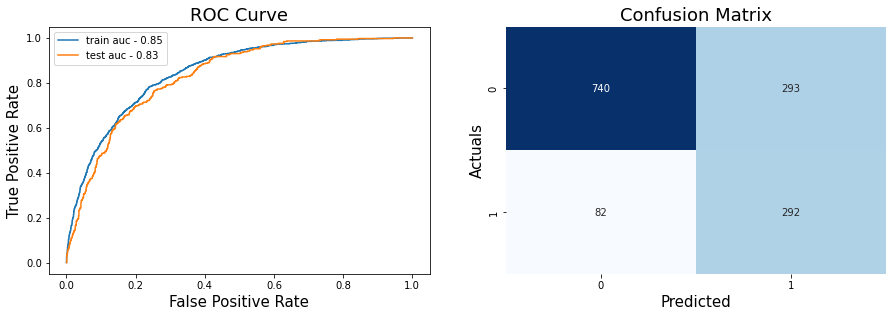

,model,accuracy_train,accuracy_test,f1_train,f1_test,roc_score,auc_score
0,LOGISTIC_REG,0.754667,0.733475,0.631804,0.608968,0.748554,0.829971


In [56]:
model_log_reg = LogisticRegression()

log_reg_param_grid = {'C' : [0.0001, 0.001, 0.05, 0.01, 0.1, 0.5, 1, 10, 100],
                  'penalty' : ['l1', 'l2', 'elasticnet', None],
                  'class_weight' : ['balanced', None]}

best_model_log_reg = model_training('LOGISTIC_REG', model_log_reg, log_reg_param_grid, X_train_le,
                                Y_train_le, random=False, scoring='f1')

log_reg_scores = evaluate_model('LOGISTIC_REG', best_model_log_reg, X_train_le, X_test_le, Y_train_le,
                                Y_test_le)

joblib.dump(best_model_log_reg, 'LogisticRegression')

validation_plots('Logistic Regression',best_model_log_reg, X_train_le, X_test_le, Y_train_le, Y_test_le)

log_reg_scores


#### 10.2 RANDOM FOREST CLASSIFIER

Training started for : RANDOM_FOREST
-------------------------------------------

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters :{'random_state': 1, 'n_estimators': 500, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'max_depth': 6, 'class_weight': 'balanced', 'bootstrap': True}

Best f1 Score : 0.64

Training Classification Report of RANDOM FOREST:
----------------------------------------------------------
              precision    recall  f1-score   support

           0       0.93      0.76      0.83      4130
           1       0.55      0.83      0.67      1495

    accuracy                           0.78      5625
   macro avg       0.74      0.80      0.75      5625
weighted avg       0.83      0.78      0.79      5625
 

Testing Classification Report of RANDOM FOREST:
----------------------------------------------------------
              precision    recall  f1-score   support

           0       0.91      0.72      0.8

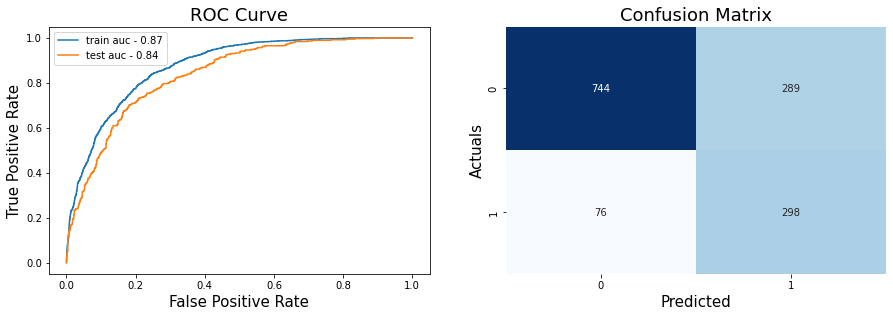

,model,accuracy_train,accuracy_test,f1_train,f1_test,roc_score,auc_score
0,RANDOM_FOREST,0.776711,0.740583,0.665067,0.620187,0.758512,0.835783


In [57]:

model_rfc = RandomForestClassifier()

rfc_param_grid = {'n_estimators': [300, 500],
            'max_features': ['sqrt'],
            'max_depth': range(5, 13),
            'min_samples_split': [2, 5, 10], 
            'min_samples_leaf': [1, 2, 3],
            'bootstrap': [True, False],
            'class_weight' : ['balanced'],
            'random_state':[1]
                 }

best_model_rfc = model_training('RANDOM_FOREST', model_rfc, rfc_param_grid, X_train_le,
                                Y_train_le, random=True, scoring='f1')

rfc_scores = evaluate_model('RANDOM_FOREST', best_model_rfc, X_train_le, X_test_le, 
                            Y_train_le, Y_test_le)


joblib.dump(best_model_rfc, 'RANDOM_FOREST')

validation_plots('RANDOM FOREST', best_model_rfc, X_train_le, X_test_le, Y_train_le, Y_test_le)

rfc_scores

#### 10.3 DECISION TREE CLASSIFIER

Training started for : DECISION_TREE
-------------------------------------------

Fitting 5 folds for each of 792 candidates, totalling 3960 fits
Best Parameters :{'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 2, 'random_state': 42, 'splitter': 'best'}

Best f1 Score : 0.62

Training Classification Report of DECISION TREE:
----------------------------------------------------------
              precision    recall  f1-score   support

           0       0.90      0.78      0.84      4130
           1       0.56      0.75      0.64      1495

    accuracy                           0.78      5625
   macro avg       0.73      0.77      0.74      5625
weighted avg       0.81      0.78      0.78      5625
 

Testing Classification Report of DECISION TREE:
----------------------------------------------------------
              precision    recall  f1-score   support

           0       0.89      0.75      0.81      1033
        

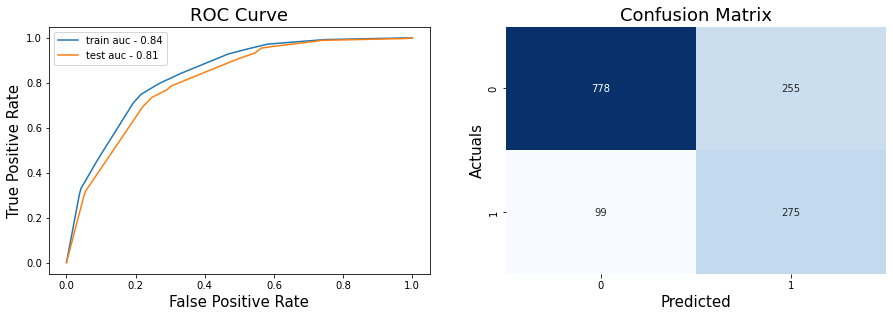

,model,accuracy_train,accuracy_test,f1_train,f1_test,roc_score,auc_score
0,DECISION_TREE,0.775111,0.748401,0.638881,0.608407,0.74422,0.809918


In [58]:

model_dtc = DecisionTreeClassifier()

dtc_param_grid = {
    "criterion": ["gini", "entropy"],   # impurity measure
    "splitter": ["best", "random"],     # strategy to choose the spnonlit at each node
    "max_depth": range(4,15),           # maximum depth of the tree
    "min_samples_split": [2, 5, 10],    # minimum number of samples required to split an internal node
    "min_samples_leaf": [1, 2, 4],      # minimum number of samples required to be at a leaf node
    "random_state": [42],               # random seed for reproducibinonlity
    'class_weight' : ['balanced', None]
}


best_model_dtc = model_training('DECISION_TREE', model_dtc, dtc_param_grid, X_train_le,
                                Y_train_le, random=False, scoring='f1')

dtc_scores = evaluate_model('DECISION_TREE', best_model_dtc, X_train_le, X_test_le,
                            Y_train_le, Y_test_le)


joblib.dump(best_model_dtc, 'DECISION_TREE')

validation_plots('DECISION TREE', best_model_dtc, X_train_le, X_test_le, Y_train_le, Y_test_le)

dtc_scores


#### 10.4 ADA BOOST CLASSIFIER

Training started for : ADABOOST
-------------------------------------------

Fitting 5 folds for each of 12 candidates, totalling 60 fits


/Users/sravaniravulaparthi/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:627: RuntimeWarning: overflow encountered in exp
  sample_weight *= np.exp(
/Users/sravaniravulaparthi/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: UserWarning: Sample weights have reached infinite values, at iteration 1, causing overflow. Iterations stopped. Try lowering the learning rate.
  estimator.fit(X_train, y_train, **fit_params)
/Users/sravaniravulaparthi/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:627: RuntimeWarning: overflow encountered in exp
  sample_weight *= np.exp(
/Users/sravaniravulaparthi/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: UserWarning: Sample weights have reached infinite values, at iteration 1, causing overflow. Iterations stopped. Try lowering the learning rate.
  estimator.fit(X_train, y_train, **fit_params)
/Users/sravaniravulaparthi

Best Parameters :{'learning_rate': 0.1, 'n_estimators': 300}

Best f1 Score : 0.59

Training Classification Report of ADA BOOST:
----------------------------------------------------------
              precision    recall  f1-score   support

           0       0.85      0.91      0.88      4130
           1       0.68      0.55      0.61      1495

    accuracy                           0.81      5625
   macro avg       0.76      0.73      0.74      5625
weighted avg       0.80      0.81      0.80      5625
 

Testing Classification Report of ADA BOOST:
----------------------------------------------------------
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1033
           1       0.64      0.52      0.57       374

    accuracy                           0.80      1407
   macro avg       0.74      0.71      0.72      1407
weighted avg       0.79      0.80      0.79      1407



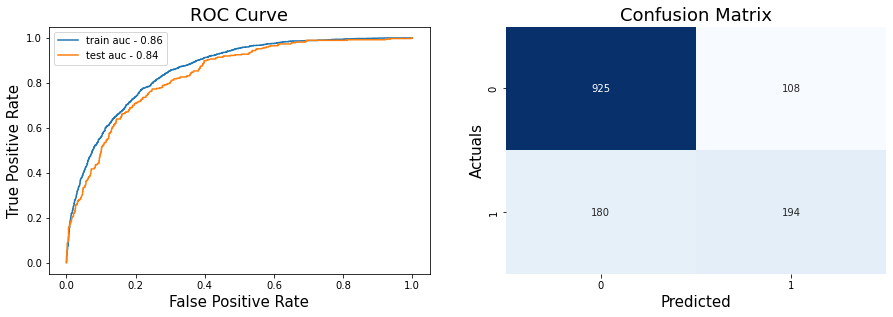

,model,accuracy_train,accuracy_test,f1_train,f1_test,roc_score,auc_score
0,ADABOOST,0.811022,0.795309,0.606733,0.573964,0.707083,0.835193


In [59]:

model_adaboost = AdaBoostClassifier()

adaboost_param_grid = {
    'n_estimators' : [300, 500],
    'learning_rate' : [0.001, 0.01, 0.1, 1, 10, 100]
}


best_model_adaboost = model_training('ADABOOST', model_adaboost, 
                                     adaboost_param_grid, X_train_le,
                                     Y_train_le, random=False, scoring='f1')

adaboost_scores = evaluate_model('ADABOOST', best_model_adaboost, X_train_le, X_test_le,
                                 Y_train_le, Y_test_le)


joblib.dump(best_model_adaboost, 'ADABOOST')

validation_plots('ADA BOOST', best_model_adaboost, X_train_le, X_test_le, Y_train_le, Y_test_le)

adaboost_scores


#### 10.5 GBDT

Training started for : GBDT
-------------------------------------------

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters :{'random_state': 42, 'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 3, 'learning_rate': 0.1}

Best f1 Score : 0.58

Training Classification Report of GBDT:
----------------------------------------------------------
              precision    recall  f1-score   support

           0       0.87      0.93      0.90      4130
           1       0.77      0.62      0.69      1495

    accuracy                           0.85      5625
   macro avg       0.82      0.78      0.79      5625
weighted avg       0.84      0.85      0.84      5625
 

Testing Classification Report of GBDT:
----------------------------------------------------------
              precision    recall  f1-score   support

           0       0.83      0.88      0.86      1033
           1       0.61      0.51      0.55       374

    accur

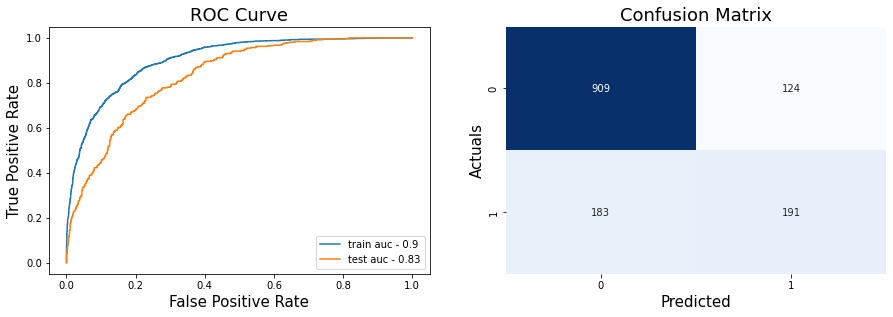

,model,accuracy_train,accuracy_test,f1_train,f1_test,roc_score,auc_score
0,GBDT,0.8496,0.781805,0.686434,0.554427,0.695328,0.831858


In [60]:
from sklearn.ensemble import GradientBoostingClassifier

model_gbdt = GradientBoostingClassifier()

gbdt_param_grid ={
    'max_depth' : range(3,10),
    'learning_rate' : [0.001, 0.01, 0.1, 1, 10],
    'n_estimators' : [300, 200],
    'min_samples_split': [2, 5], 
    'min_samples_leaf': [1, 2, 3],
    'random_state' : [42]
}

best_model_gbdt = model_training('GBDT', model_gbdt, 
                                     gbdt_param_grid, X_train_le,
                                     Y_train_le, random=True, scoring='f1')

gbdt_scores = evaluate_model('GBDT', best_model_gbdt, X_train_le, X_test_le,
                                 Y_train_le, Y_test_le)


joblib.dump(best_model_gbdt, 'GBDT')

validation_plots('GBDT', best_model_gbdt, X_train_le, X_test_le, Y_train_le, Y_test_le)

gbdt_scores


#### 10.6 XGBOOST

Training started for : XGBOOST
-------------------------------------------

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters :{'n_estimators': 100, 'min_child_weight': 0.5, 'max_depth': 5, 'lambda': 0.5, 'gamma': 1.0, 'colsample_bytree': 0.1}

Best f1 Score : 0.57

Training Classification Report of XG BOOST:
----------------------------------------------------------
              precision    recall  f1-score   support

           0       0.85      0.92      0.89      4130
           1       0.73      0.57      0.64      1495

    accuracy                           0.83      5625
   macro avg       0.79      0.74      0.76      5625
weighted avg       0.82      0.83      0.82      5625
 

Testing Classification Report of XG BOOST:
----------------------------------------------------------
              precision    recall  f1-score   support

           0       0.83      0.88      0.86      1033
           1       0.61      0.51      0.55       374

    accu

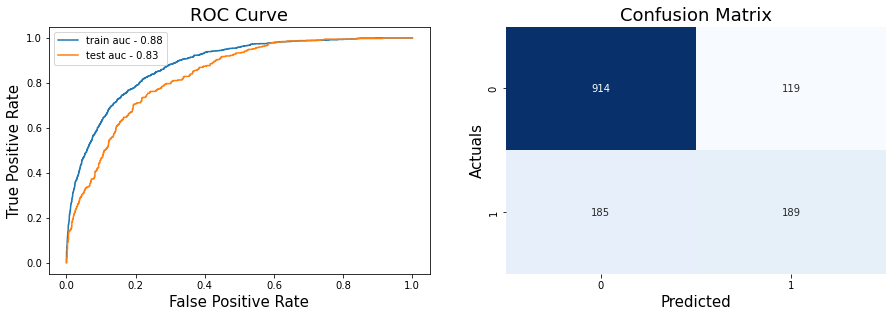

,model,accuracy_train,accuracy_test,f1_train,f1_test,roc_score,auc_score
0,XGBOOST,0.828089,0.783937,0.636876,0.554252,0.695075,0.832208


In [61]:

model_xgboost = xgb.XGBClassifier(random_state = 42, nthread = -1, n_jobs = -1)

param_values = [0.1, 0.5, 0.9, 1.0]
xgboost_param_grid = {
    'max_depth' : range(3,10),
    'gamma' : param_values,
    'colsample_bytree' : param_values,
    'lambda' : param_values,
    'n_estimators' : [300, 100],
    'min_child_weight' : param_values
}

best_model_xgboost = model_training('XGBOOST', model_xgboost, 
                                     xgboost_param_grid, X_train_le,
                                     Y_train_le, random=True, scoring='f1')

xgboost_scores = evaluate_model('XGBOOST', best_model_xgboost, X_train_le, X_test_le,
                                 Y_train_le, Y_test_le)


joblib.dump(best_model_xgboost, 'XGBOOST')

validation_plots('XG BOOST', best_model_xgboost, X_train_le, X_test_le, Y_train_le, Y_test_le)

xgboost_scores


### 11. MODEL COMPARISON

In [62]:
# Comparing Models
final_scores = pd.concat([log_reg_scores, dtc_scores, rfc_scores, adaboost_scores, 
                          gbdt_scores, xgboost_scores]).reset_index(drop=True)

final_scores

,model,accuracy_train,accuracy_test,f1_train,f1_test,roc_score,auc_score
0,LOGISTIC_REG,0.754667,0.733475,0.631804,0.608968,0.748554,0.829971
1,DECISION_TREE,0.775111,0.748401,0.638881,0.608407,0.744220,0.809918
2,RANDOM_FOREST,0.776711,0.740583,0.665067,0.620187,0.758512,0.835783
3,ADABOOST,0.811022,0.795309,0.606733,0.573964,0.707083,0.835193
4,GBDT,0.849600,0.781805,0.686434,0.554427,0.695328,0.831858
5,XGBOOST,0.828089,0.783937,0.636876,0.554252,0.695075,0.832208


### 12. SMOTE ANALYSIS

#### 12.1 Logistic Regression

Before SMOTE:
-------------------
Number of positive samples: 1495
Number of negative samples: 4130

Performing SMOTE for LOGISTIC_REG......

After SMOTE:
-------------------
Number of positive samples: 4130
Number of negative samples: 4130

Training started for : LOGISTIC_REG
----------------------------------------

Fitting 5 folds for each of 72 candidates, totalling 360 fits


/Users/sravaniravulaparthi/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/sravaniravulaparthi/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/sravaniravulaparthi/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/sravaniravulaparthi/opt/anaconda3/lib/python3.9/s

/Users/sravaniravulaparthi/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/sravaniravulaparthi/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/mod

/Users/sravaniravulaparthi/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/sravaniravulaparthi/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/sravaniravulaparthi/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or

/Users/sravaniravulaparthi/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/sravaniravulaparthi/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/sravaniravulaparthi/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or

/Users/sravaniravulaparthi/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/sravaniravulaparthi/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/mod

/Users/sravaniravulaparthi/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/sravaniravulaparthi/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/mod

/Users/sravaniravulaparthi/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/sravaniravulaparthi/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/mod

/Users/sravaniravulaparthi/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/sravaniravulaparthi/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/sravaniravulaparthi/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/sravaniravulaparthi/opt/anaconda3/lib/python3.9/s

Best Parameters :{'C': 0.5, 'class_weight': 'balanced', 'penalty': 'l2'}
Best f1 Score : 0.80

Training Classification Report of SMOTE_LOGISTIC_REG:
----------------------------------------------------------
              precision    recall  f1-score   support

           0       0.89      0.78      0.83      4130
           1       0.55      0.73      0.62      1495

    accuracy                           0.77      5625
   macro avg       0.72      0.75      0.73      5625
weighted avg       0.80      0.77      0.78      5625
 

Testing Classification Report of SMOTE_LOGISTIC_REG:
----------------------------------------------------------
              precision    recall  f1-score   support

           0       0.88      0.76      0.82      1033
           1       0.52      0.72      0.60       374

    accuracy                           0.75      1407
   macro avg       0.70      0.74      0.71      1407
weighted avg       0.78      0.75      0.76      1407



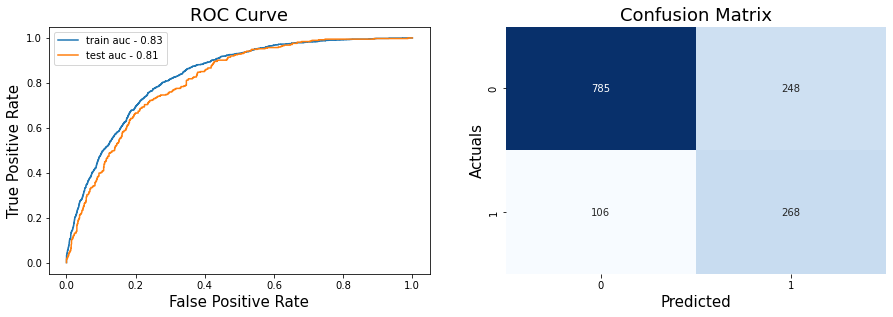

,model,accuracy_train,accuracy_test,f1_train,f1_test,roc_score,auc_score
0,SMOTE_LOGISTIC_REG,0.766578,0.748401,0.623459,0.602247,0.73825,0.810296


In [63]:
smote_log_reg = LogisticRegression()

smote_log_reg_param_grid = {'C' : [0.0001, 0.001, 0.05, 0.01, 0.1, 0.5, 1, 10, 100],
                  'penalty' : ['l1', 'l2', 'elasticnet', None],
                  'class_weight' : ['balanced', None]}

smote_model_log_reg = smote_analysis('LOGISTIC_REG', smote_log_reg, smote_log_reg_param_grid, X_train_le,
                                Y_train_le, smote=True,random=False, scoring='f1')

smote_log_reg_scores = evaluate_model('SMOTE_LOGISTIC_REG', smote_model_log_reg, X_train_le, X_test_le, Y_train_le,
                                Y_test_le)

joblib.dump(smote_model_log_reg, 'SMOTE_LOGISTIC_REG')

validation_plots('SMOTE_LOGISTIC_REG', smote_model_log_reg, X_train_le, X_test_le, Y_train_le, Y_test_le)

smote_log_reg_scores

#### 12.2 RANDOM FOREST CLASSIFIER

Before SMOTE:
-------------------
Number of positive samples: 1495
Number of negative samples: 4130

Performing SMOTE for RANDOM_FOREST......

After SMOTE:
-------------------
Number of positive samples: 4130
Number of negative samples: 4130

Training started for : RANDOM_FOREST
----------------------------------------

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters :{'random_state': 1, 'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 11, 'class_weight': 'balanced', 'bootstrap': True}
Best f1 Score : 0.84

Training Classification Report of SMOTE_RANDOM_FOREST:
----------------------------------------------------------
              precision    recall  f1-score   support

           0       0.96      0.89      0.92      4130
           1       0.74      0.89      0.81      1495

    accuracy                           0.89      5625
   macro avg       0.85      0.89      0.86      5625
weighted avg    

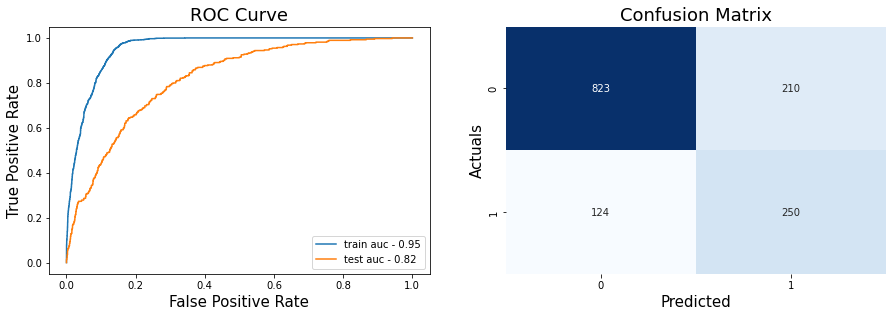

,model,accuracy_train,accuracy_test,f1_train,f1_test,roc_score,auc_score
0,SMOTE_RANDOM_FOREST,0.888,0.762615,0.808975,0.59952,0.732579,0.81742


In [64]:
smote_rfc = RandomForestClassifier()

rfc_param_grid = {'n_estimators': [300, 500],
            'max_features': ['sqrt'],
            'max_depth': range(5, 13),
            'min_samples_split': [2, 5, 10], 
            'min_samples_leaf': [1, 2, 3],
            'bootstrap': [True, False],
            'class_weight' : ['balanced'],
            'random_state':[1]
                 }

smote_model_rfc = smote_analysis('RANDOM_FOREST', smote_rfc, rfc_param_grid, X_train_le,
                                Y_train_le, random=True, scoring='f1')

smote_rfc_scores = evaluate_model('SMOTE_RANDOM_FOREST', smote_model_rfc, X_train_le, X_test_le, 
                            Y_train_le, Y_test_le)


joblib.dump(smote_model_rfc, 'Smote_Random_Forest')

validation_plots('SMOTE_RANDOM_FOREST', smote_model_rfc, X_train_le, X_test_le, Y_train_le, Y_test_le)

smote_rfc_scores


#### 12.3 DECISION TREE CLASSIFIER  

Before SMOTE:
-------------------
Number of positive samples: 1495
Number of negative samples: 4130

Performing SMOTE for DECISION_TREE......

After SMOTE:
-------------------
Number of positive samples: 4130
Number of negative samples: 4130

Training started for : DECISION_TREE
----------------------------------------

Fitting 5 folds for each of 792 candidates, totalling 3960 fits
Best Parameters :{'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 9, 'min_samples_leaf': 2, 'min_samples_split': 2, 'random_state': 42, 'splitter': 'best'}
Best f1 Score : 0.82

Training Classification Report of SMOTE_DECISION_TREE:
----------------------------------------------------------
              precision    recall  f1-score   support

           0       0.93      0.82      0.87      4130
           1       0.62      0.82      0.71      1495

    accuracy                           0.82      5625
   macro avg       0.77      0.82      0.79      5625
weighted avg       0.85      0.82   

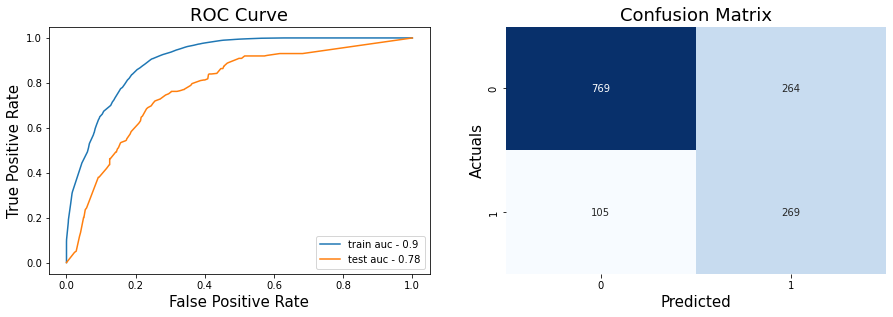

,model,accuracy_train,accuracy_test,f1_train,f1_test,roc_score,auc_score
0,SMOTE_DECISION_TREE,0.8192,0.73774,0.706832,0.593164,0.731843,0.779278


In [65]:
smote_dtc = DecisionTreeClassifier()

dtc_param_grid = {
    "criterion": ["gini", "entropy"],   # impurity measure
    "splitter": ["best", "random"],     # strategy to choose the spnonlit at each node
    "max_depth": range(4,15),           # maximum depth of the tree
    "min_samples_split": [2, 5, 10],    # minimum number of samples required to spnonlit an internal node
    "min_samples_leaf": [1, 2, 4],      # minimum number of samples required to be at a leaf node
    "random_state": [42],               # random seed for reproducibinonlity
    'class_weight' : ['balanced', None]
}


smote_model_dtc = smote_analysis('DECISION_TREE', smote_dtc, dtc_param_grid, X_train_le,
                                Y_train_le, random=False, scoring='f1')

smote_dtc_scores = evaluate_model('SMOTE_DECISION_TREE', smote_model_dtc, X_train_le, X_test_le,
                            Y_train_le, Y_test_le)


joblib.dump(smote_model_dtc, 'SMOTE_DECISION_TREE')

validation_plots('SMOTE_DECISION_TREE', smote_model_dtc, X_train_le, X_test_le, Y_train_le, Y_test_le)

smote_dtc_scores

#### 12.4 ADA BOOST CLASSIFIER

Before SMOTE:
-------------------
Number of positive samples: 1495
Number of negative samples: 4130

Performing SMOTE for ADABOOST......

After SMOTE:
-------------------
Number of positive samples: 4130
Number of negative samples: 4130

Training started for : ADABOOST
----------------------------------------

Fitting 5 folds for each of 12 candidates, totalling 60 fits


/Users/sravaniravulaparthi/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:627: RuntimeWarning: overflow encountered in exp
  sample_weight *= np.exp(
/Users/sravaniravulaparthi/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: UserWarning: Sample weights have reached infinite values, at iteration 1, causing overflow. Iterations stopped. Try lowering the learning rate.
  estimator.fit(X_train, y_train, **fit_params)
/Users/sravaniravulaparthi/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:627: RuntimeWarning: overflow encountered in exp
  sample_weight *= np.exp(
/Users/sravaniravulaparthi/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: UserWarning: Sample weights have reached infinite values, at iteration 1, causing overflow. Iterations stopped. Try lowering the learning rate.
  estimator.fit(X_train, y_train, **fit_params)
/Users/sravaniravulaparthi

Best Parameters :{'learning_rate': 0.1, 'n_estimators': 500}
Best f1 Score : 0.82

Training Classification Report of SMOTE_ADA_BOOST:
----------------------------------------------------------
              precision    recall  f1-score   support

           0       0.90      0.77      0.83      4130
           1       0.55      0.76      0.63      1495

    accuracy                           0.77      5625
   macro avg       0.72      0.76      0.73      5625
weighted avg       0.80      0.77      0.78      5625
 

Testing Classification Report of SMOTE_ADA_BOOST:
----------------------------------------------------------
              precision    recall  f1-score   support

           0       0.89      0.75      0.81      1033
           1       0.52      0.75      0.61       374

    accuracy                           0.75      1407
   macro avg       0.70      0.75      0.71      1407
weighted avg       0.79      0.75      0.76      1407



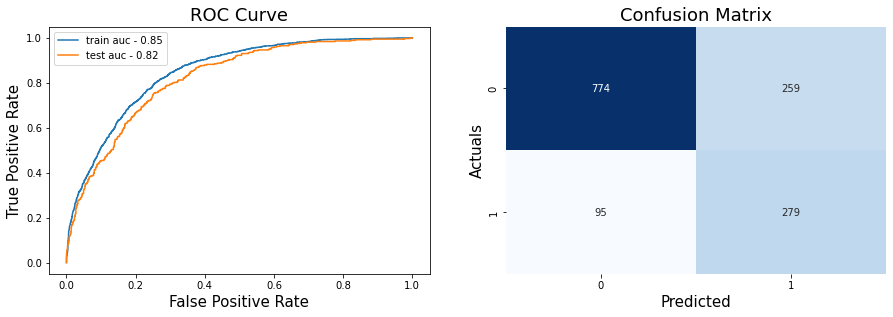

,model,accuracy_train,accuracy_test,f1_train,f1_test,roc_score,auc_score
0,SMOTE_ADABOOST,0.767822,0.748401,0.633558,0.611842,0.747632,0.820511


In [66]:
smote_adaboost = AdaBoostClassifier()

adaboost_param_grid = {
    'n_estimators' : [300, 500],
    'learning_rate' : [0.001, 0.01, 0.1, 1, 10, 100]
}


smote_model_adaboost = smote_analysis('ADABOOST', smote_adaboost, 
                                     adaboost_param_grid, X_train_le,
                                     Y_train_le, random=False, scoring='f1')

smote_adaboost_scores = evaluate_model('SMOTE_ADABOOST', smote_model_adaboost, X_train_le, X_test_le,
                                 Y_train_le, Y_test_le)


joblib.dump(smote_model_adaboost, 'SMOTE_ADABOOST')

validation_plots('SMOTE_ADA_BOOST', smote_model_adaboost, X_train_le, X_test_le, Y_train_le, Y_test_le)

smote_adaboost_scores


#### 12.5 GBDT

Before SMOTE:
-------------------
Number of positive samples: 1495
Number of negative samples: 4130

Performing SMOTE for GBDT......

After SMOTE:
-------------------
Number of positive samples: 4130
Number of negative samples: 4130

Training started for : GBDT
----------------------------------------

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters :{'random_state': 42, 'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 7, 'learning_rate': 0.1}
Best f1 Score : 0.83

Training Classification Report of SMOTE GBDT:
----------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      4130
           1       0.93      0.96      0.95      1495

    accuracy                           0.97      5625
   macro avg       0.96      0.97      0.97      5625
weighted avg       0.97      0.97      0.97      5625
 

Testing Classification Report of SM

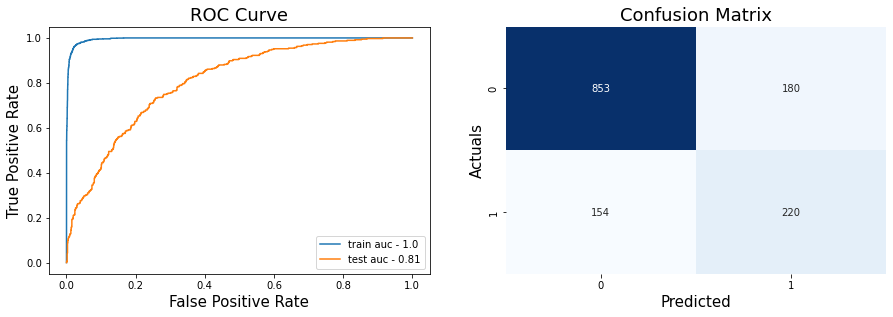

,model,accuracy_train,accuracy_test,f1_train,f1_test,roc_score,auc_score
0,SMOTE_GBDT,0.972444,0.762615,0.948996,0.568475,0.706993,0.806647


In [67]:

smote_gbdt = GradientBoostingClassifier()

gbdt_param_grid ={
    'max_depth' : range(3,10),
    'learning_rate' : [0.001, 0.01, 0.1, 1, 10],
    'n_estimators' : [300, 200],
    'min_samples_split': [2, 5], 
    'min_samples_leaf': [1, 2, 3],
    'random_state' : [42]
}

smote_model_gbdt = smote_analysis('GBDT', smote_gbdt, 
                                     gbdt_param_grid, X_train_le,
                                     Y_train_le, random=True, scoring='f1')

smote_gbdt_scores = evaluate_model('SMOTE_GBDT', smote_model_gbdt, X_train_le, X_test_le,
                                 Y_train_le, Y_test_le)


joblib.dump(smote_model_gbdt, 'SMOTE_GBDT')

validation_plots('SMOTE GBDT', smote_model_gbdt, X_train_le, X_test_le, Y_train_le, Y_test_le)

smote_gbdt_scores


#### 12.6 XG BOOST

Before SMOTE:
-------------------
Number of positive samples: 1495
Number of negative samples: 4130

Performing SMOTE for XGBOOST......

After SMOTE:
-------------------
Number of positive samples: 4130
Number of negative samples: 4130

Training started for : XGBOOST
----------------------------------------

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters :{'n_estimators': 100, 'min_child_weight': 0.9, 'max_depth': 8, 'lambda': 1.0, 'gamma': 0.1, 'colsample_bytree': 1.0}
Best f1 Score : 0.83

Training Classification Report of SMOTE_XG_BOOST:
----------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      4130
           1       0.95      0.99      0.97      1495

    accuracy                           0.98      5625
   macro avg       0.97      0.98      0.98      5625
weighted avg       0.98      0.98      0.98      5625
 

Testing Classification Report of SM

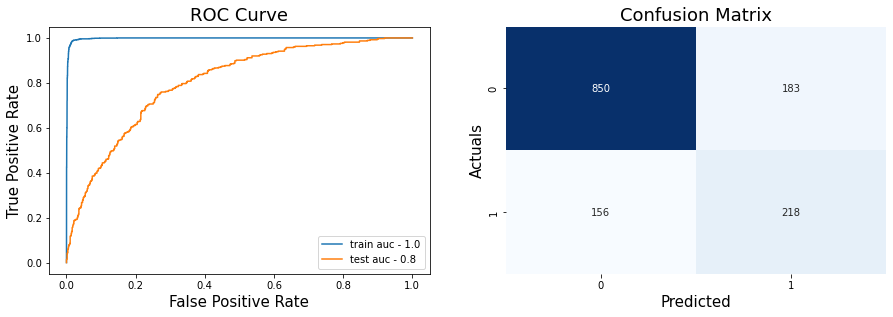

,model,accuracy_train,accuracy_test,f1_train,f1_test,roc_score,auc_score
0,SMOTE_XGBOOST,0.9824,0.759062,0.967573,0.562581,0.702867,0.801743


In [68]:
smote_xgboost = xgb.XGBClassifier(random_state = 42, nthread = -1, n_jobs = -1)

param_values = [0.1, 0.5, 0.9, 1.0]
xgboost_param_grid = {
    'max_depth' : range(3,10),
    'gamma' : param_values,
    'colsample_bytree' : param_values,
    'lambda' : param_values,
    'n_estimators' : [300, 100],
    'min_child_weight' : param_values
}

smote_model_xgboost = smote_analysis('XGBOOST', smote_xgboost, 
                                     xgboost_param_grid, X_train_le,
                                     Y_train_le, random=True, scoring='f1')

smote_xgboost_scores = evaluate_model('SMOTE_XGBOOST', smote_model_xgboost, X_train_le, X_test_le,
                                 Y_train_le, Y_test_le)


joblib.dump(smote_model_xgboost, 'SMOTE_XGBOOST')

validation_plots('SMOTE_XG_BOOST', smote_model_xgboost, X_train_le, X_test_le, Y_train_le, Y_test_le)

smote_xgboost_scores


### 13. SMOTE MODEL COMPARISION

In [69]:
# Comparing Models
smote_final_scores = pd.concat([smote_log_reg_scores, smote_dtc_scores, 
                          smote_rfc_scores, smote_adaboost_scores, 
                          smote_gbdt_scores, smote_xgboost_scores]).reset_index(drop=True)

smote_final_scores

,model,accuracy_train,accuracy_test,f1_train,f1_test,roc_score,auc_score
0,SMOTE_LOGISTIC_REG,0.766578,0.748401,0.623459,0.602247,0.738250,0.810296
1,SMOTE_DECISION_TREE,0.819200,0.737740,0.706832,0.593164,0.731843,0.779278
2,SMOTE_RANDOM_FOREST,0.888000,0.762615,0.808975,0.599520,0.732579,0.817420
3,SMOTE_ADABOOST,0.767822,0.748401,0.633558,0.611842,0.747632,0.820511
4,SMOTE_GBDT,0.972444,0.762615,0.948996,0.568475,0.706993,0.806647
5,SMOTE_XGBOOST,0.982400,0.759062,0.967573,0.562581,0.702867,0.801743


In [70]:
total_final_scores = pd.concat([final_scores, smote_final_scores]).reset_index(drop=True)
total_final_scores.sort_values(by='roc_score', ascending=False)

,model,accuracy_train,accuracy_test,f1_train,f1_test,roc_score,auc_score
2,RANDOM_FOREST,0.776711,0.740583,0.665067,0.620187,0.758512,0.835783
0,LOGISTIC_REG,0.754667,0.733475,0.631804,0.608968,0.748554,0.829971
9,SMOTE_ADABOOST,0.767822,0.748401,0.633558,0.611842,0.747632,0.820511
1,DECISION_TREE,0.775111,0.748401,0.638881,0.608407,0.744220,0.809918
6,SMOTE_LOGISTIC_REG,0.766578,0.748401,0.623459,0.602247,0.738250,0.810296
8,SMOTE_RANDOM_FOREST,0.888000,0.762615,0.808975,0.599520,0.732579,0.817420
7,SMOTE_DECISION_TREE,0.819200,0.737740,0.706832,0.593164,0.731843,0.779278
3,ADABOOST,0.811022,0.795309,0.606733,0.573964,0.707083,0.835193
10,SMOTE_GBDT,0.972444,0.762615,0.948996,0.568475,0.706993,0.806647
11,SMOTE_XGBOOST,0.982400,0.759062,0.967573,0.562581,0.702867,0.801743


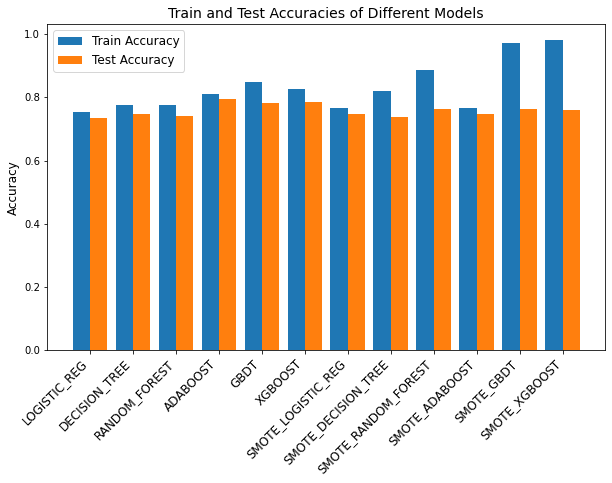

In [71]:
# Get the model names, train accuracies and test accuracies
model_names = total_final_scores['model']
train_acc = total_final_scores['accuracy_train']
test_acc = total_final_scores['accuracy_test']

# Set the x-axis ticks
x = np.arange(len(model_names))

# Create the figure and axes objects
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the train accuracy bars
ax.bar(x - 0.2, train_acc, width=0.4, label='Train Accuracy')

# Plot the test accuracy bars
ax.bar(x + 0.2, test_acc, width=0.4, label='Test Accuracy')

# Add labels and title
ax.set_xticks(x)
ax.set_xticklabels(model_names, rotation=45, ha='right', fontsize=12)
ax.set_ylabel('Accuracy', fontsize=12)
ax.set_title('Train and Test Accuracies of Different Models', fontsize=14)
ax.legend(fontsize=12)

# Display the plot
plt.show()


### Conclusion:

Businesses may take proactive steps to keep customers and reduce churn by precisely forecasting customer attrition. We utilized Machine learning algorithms to predict customer churn.

*   On Unbalanced Data, Adaboost, Random Forest and XGBoost has performed well with 83% auc score and 75.8% roc score 
*   On Balancing the data using SMOTE technique, Random Forest has performed well with 82% auc score 89% train accuracy and 76% test accuracy

*   By taking the necessary measures to confirm that the model is 
accurate and not overfitting the data, we can identify the customers who are potential churners.
* Created a web app utilizing streamlit that predicts customer churn using the Random Forest model.